In [1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import sagemaker
import boto3 
import s3fs
import json
import datetime
from tzlocal import get_localzone as tzlocal
import numpy as np
import os
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3 


# Training and endpoint creation of a DeepAR model for time series prediction
>DeepAR is a time series prediction model offered by AWS Sagemaker (https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html).  

Its core feature is being able to learn from different time series simultaneously (called `targets`), and also from their associated `dynamic_features`. For more clarity: 
- Each `target` could represent the monthly traffic in a given city 
- And its associated `dynamic_feat` could be the local gas prices & weather conditions.
- We did not use the categorical features `cat`, but it could be useful in future development.

The correct input format this algorithm expects is the following, with each line representing a target time series: 
```
{"start": "2009-11-01 00:00:00", "target": [4.3, "NaN", 5.1, ...], "cat": [0, 1], "dynamic_feat": [[1.1, 1.2, 0.5, ...]]} 
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [2, 3], "dynamic_feat": [[1.1, 2.05, ...]]}
{"start": "1999-01-30 00:00:00", "target": [2.0, 1.0], "cat": [1, 4], "dynamic_feat": [[1.3, 0.4]]}
```

**Warning: on one month data, training should take 1~2h. Once started, stopping the kernel does NOT stop training.**

In [ ]:
# ARN of the role used during training. This role needs access in particular to S3, since it's where our data resides.
role = 'arn:aws:iam::746022503515:role/sage_maker'
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')
data_bucket_name = 'fog-datasets'
prefix = 'deep_ar'
s3_data_path = "{}/{}/data".format(data_bucket_name, prefix)
s3_output_path = "{}/{}/output".format(data_bucket_name, prefix)

train_locally = False
train_instance_type = 'ml.m5.2xlarge'

sagemaker_session = sagemaker.Session()

# Create a Sagemaker estimator. It is an abstraction used by sagemaker representing our model
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type=train_instance_type,
    base_job_name='Weekly-Deepar',
    output_path="s3://" + s3_output_path
)

# Number of datapoints per week. The division by 5 reflects the fact that we aggregated the data by 5 min buckets
one_week_datapoints = 7*(60*24)//5

# Some hyperparameters to tune the training. 
hyperparameters = dict(
    time_freq=data_freq,
    context_length=str(one_week_datapoints), # reflects how many past datapoints are being used during inference 
    prediction_length=str(one_week_datapoints), #reflects how many datapoints we want to predict during inference
    num_cells="40",
    num_layers="3",
    likelihood="gaussian",
    epochs="20",
    mini_batch_size="32",
    learning_rate="0.001",
    dropout_rate="0.05",
    early_stopping_patience="10"
)

estimator.set_hyperparameters(**hyperparameters)

# Channels are a data source abstraction from sagemaker, it just feeds correctly our data during training & testing.
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

# Run the training job!
estimator.fit(inputs=data_channels)

Now that we have a finished training job, we can create an endpoint from it and deploy it to AWS for inference!

In [35]:
# Create endpoint
from deep_ar import DeepARPredictor
from sagemaker.amazon.amazon_estimator import get_image_uri

job_name = estimator.latest_training_job.name

role = 'arn:aws:iam::746022503515:role/sage_maker'
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: Weekly-Deepar-2019-02-23-20-41-14-700
INFO:sagemaker:Creating endpoint-config with name Weekly-Deepar-2019-02-23-20-41-14-700
INFO:sagemaker:Creating endpoint with name Weekly-Deepar-2019-02-23-20-41-14-700


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateEndpoint operation: The account-level service limit 'Number of instances across active endpoints' is 3 Instances, with current utilization of 3 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

- Now that the endpoint is created, it is ready to receive inference calls from other pieces of software

In [7]:
from deep_ar import DeepARPredictor
sagemaker_session = sagemaker.Session()


predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)



In [15]:
data_bucket_name = 'fog-datasets'
prefix = 'deep_ar'
s3_data_path = "{}/{}/data".format(data_bucket_name, prefix)

train_df = pd.read_csv("s3://{}/train/data.json".format(s3_data_path))
train_data = pd.Series(data=train_df.SampleCount.values, index=[i.replace(tzinfo=None) for i in pd.to_datetime(train_df.index)])
train_idx = train_data.index

test_df = pd.read_csv("s3://{}/test/data.json".format(s3_data_path))
train_data = pd.Series(data=test_df.SampleCount.values, index=[i.replace(tzinfo=None) for i in pd.to_datetime(test_df.index)])
test_idx = test_data.index




AttributeError: 'DataFrame' object has no attribute 'SampleCount'

In [19]:
print(train_df.head())
dyn = [
    list(weekends_feature_series[train_idx][-len(series[test_idx]):])+[0 if i.weekday() < 5 else 1 for i in series[test_idx].index]
]
#predictor.set_prediction_parameters(freq=data_freq, prediction_length=len(series[test_idx]))
#predictions = predictor.predict([series[train_idx][-len(series[test_idx]):]], 
#                                dyn)


Empty DataFrame
Columns: [{"start": "2018-12-20 16:25:00",  "target": [392263.60000000003,  440813.4,  489368.4,  487068.0,  484785.00000000006,  482888.6,  480921.6,  478118.8,  475042.39999999997,  469905.8,  462794.0,  454761.4,  446682.60000000003,  438762.80000000005,  430353.60000000003,  420309.00000000006,  409270.4,  397356.2,  384862.4,  372378.0,  360872.6,  348764.4,  336804.6,  325331.0,  314433.60000000003,  303961.4,  294652.2,  285326.39999999997,  276030.4,  267009.80000000005,  257702.40000000002,  248260.2,  238987.20000000004,  229505.00000000003,  219859.2,  210476.4,  201844.0,  193720.59999999998,  186583.0,  179774.0,  173863.40000000002,  168231.40000000002,  163022.0,  157967.8,  153150.40000000002,  148087.6,  142945.0,  138230.6,  133707.4,  129566.4,  125975.40000000001,  122945.6,  120261.20000000001,  118068.6,  116111.00000000001,  114070.0,  111868.8,  109350.6,  106438.8,  103404.8,  100554.20000000001,  97837.60000000002,  95057.40000000001,  92493.4,

NameError: name 'weekends_feature_series' is not defined

<Figure size 864x432 with 0 Axes>

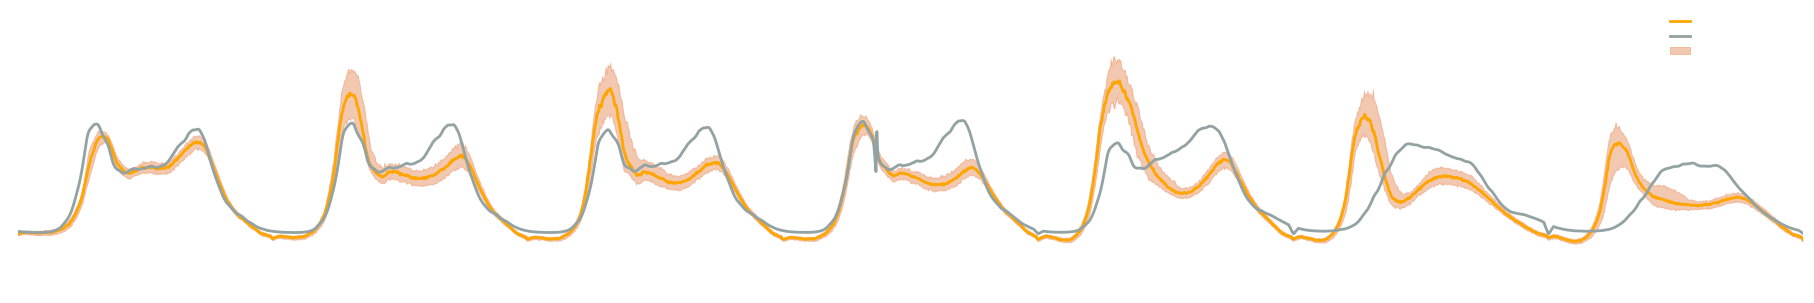

In [26]:
for k in range(len(predictions)):
    plt.figure(figsize=(12,6))
    # series[test_idx].plot(label='target')
    p10 = predictions[k]['0.1']
    p90 = predictions[k]['0.9']
    #plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    #predictions[k]['0.5'].plot(label='prediction median')
    #plt.legend()
    #plt.show()

    
    fig, ax = plt.subplots(1,figsize=(32,5))

    c = 'white'
    ax.plot(np.arange(len(predictions[k])),predictions[k]["0.5"].values,linewidth=2.8,color='orange',label='Expected Value')
    ax.plot(np.arange(len(series[test_idx])),series[test_idx].values, label='Ground truth',color="#93A2A2",linewidth=2.8)
    ax.fill_between(
        np.arange(len(predictions[k])),
        p10, 
        p90,
        color='#E99365',
        alpha=0.5,
        label='Standard Deviation'
    )
    ax.set_ylim(-100000,500000)
    ax.set_yticks(np.linspace(0,500000,4))
    ax.set_yticklabels(np.linspace(0,3,4,dtype='int'))
    #     ax.set_ylabel('100k requests per 5min',fontdict=dict(color=c,size=10))
    ax.axes.yaxis.set_visible(False)
    ax.set_xticks(np.linspace(0,len(predictions[k]),8))
    ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    ax.set_xlim(0,len(predictions[k]))
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_alpha(0)
    ax.spines['top'].set_color('grey') 
    ax.spines['top'].set_alpha(0)
    ax.spines['right'].set_color('grey')
    ax.spines['right'].set_alpha(0)
    ax.spines['left'].set_color('grey')
    ax.spines['left'].set_alpha(0)
    ax.tick_params(axis='x', colors=c)
    ax.tick_params(axis='y', colors=c)
    ax.title.set_color(c)
    ax.legend(prop={'size': 20})

    l = ax.legend(framealpha=0)
    for text in l.get_texts():
        text.set_color(c)
    fig.savefig('plots/deepar_no_dyn.png',transparent=True)